# Image Scene Classification of Multiclass

In this notebook, I fine-tuned the pre-trained model EfficientNet-B7 to use on the Intel Image Classification dataset. First, the tunning is run on the SageMaker training jobs to utilize the ml.g4dn.xlarge instance type. Meanwhile, I used the model profiler and debugger to analyze the generated model. Then I deploy the model and inference random image sets.

In [18]:
#Install needed packages
!pip install smdebug
!pip install kaggle
!pip install torchvision

Keyring is skipped due to an exception: 'keyring.backends'
Keyring is skipped due to an exception: 'keyring.backends'
Keyring is skipped due to an exception: 'keyring.backends'
  Using cached torchvision-0.14.1-cp37-cp37m-manylinux1_x86_64.whl (24.2 MB)


In [2]:
#Import some of the needed packages
import sagemaker
import boto3
import pandas as pd
import numpy as np

%matplotlib inline

## Dataset
The data set I'm using is the Intel Image Classification dataset available on (https://www.kaggle.com/datasets/puneet6060/intel-image-classification). This data set consists of images of natural scenes around the world under 6 categories:

- Buildings
- Forest
- Glacier
- Mountain
- Sea
- Street

There are a total of 25k images of size 150x150, distributed between Train, Test, and Prediction files. where, 14k images are in Train, 3k in Test, and 7k in Prediction.

The dataset file structure is like this

```
.   
└───data
    └───seg_train
    │   │   
    │   └───buildings
    │   └───forest
    │   └───glacier
    │   └───mountain
    │   └───sea
    │   └───street
    │
    └───seg_test
    │   │   
    │   └───buildings
    │   └───forest
    │   └───glacier
    │   └───mountain
    │   └───sea
    │   └───street
    │
    └───seg_pred

```
Each category is in a separate file.

In [4]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "g**************"
kaggle_key = "7**********************************"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

In [7]:
# Download and unzip the dataset using kaggle CLI
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip -n -q intel-image-classification.zip

intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [97]:
#Retrieve the role, sagemaker_session, bucket, and prefix used in the notebook.
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix = "project3"
role = sagemaker.get_execution_role()

In [6]:
#Upload the data to S3 bucket in my account
inputs = sagemaker_session.upload_data(path="data", bucket=bucket, key_prefix=prefix)
print("S3 path: {}".format(inputs))

S3 path: s3://sagemaker-us-east-1-966212731481/project3


## Hyperparameter Tuning
`hpo.py` script is mandatory to act as entry poitn to perform hyperparameter tuning.

In [7]:
#Import the needed tuner modules
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

In [8]:
#Declare the hyperparameters and their ranges.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([128, 256, 512]),
    "epochs": CategoricalParameter([5, 7, 9]),
    "eps": ContinuousParameter(0.0000001, 0.000001),
}

In [11]:
#Create estimators for the hyperparameters
from sagemaker.pytorch import PyTorch
estimator = PyTorch(
    entry_point="hpo.py",
    source_dir="code",
    role=role,
    py_version='py38',
    framework_version="1.10",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)

# Devine the HyperparameterTuner
objective_metric_name = "test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "test loss", "Regex": "Testing - loss: ([0-9\\.]+)"}]

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs = 6,
    max_parallel_jobs = 2,
    objective_type = objective_type,
)

In [12]:
#Start the tuning job
tuner.fit({"training": inputs }, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


............................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [63]:
# View the Hyperparameter Tuning job
from sagemaker.analytics import HyperparameterTuningJobAnalytics

analyt = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-230111-0846')

analyt_df = analyt.dataframe()

analyt_df.sort_values('FinalObjectiveValue', ascending=0)

,batch_size,epochs,eps,lr,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
2,"""128""","""7""",1.041494e-07,0.078556,pytorch-training-230111-0846-004-99ee894a,Completed,1.8833,2023-01-11 09:01:03+00:00,2023-01-11 09:10:37+00:00,574.0
3,"""512""","""9""",9.837899e-07,0.046295,pytorch-training-230111-0846-003-6614129d,Completed,0.8884,2023-01-11 08:58:46+00:00,2023-01-11 09:12:01+00:00,795.0
0,"""512""","""7""",9.905316e-07,0.040166,pytorch-training-230111-0846-006-996b3e62,Completed,0.8648,2023-01-11 09:12:16+00:00,2023-01-11 09:21:59+00:00,583.0
5,"""128""","""5""",1.966739e-07,0.020436,pytorch-training-230111-0846-001-74802d9b,Completed,0.7446,2023-01-11 08:47:44+00:00,2023-01-11 08:58:22+00:00,638.0
4,"""512""","""7""",9.841991e-07,0.027307,pytorch-training-230111-0846-002-d75156bb,Completed,0.6718,2023-01-11 08:47:37+00:00,2023-01-11 09:00:46+00:00,789.0
1,"""128""","""7""",3.253526e-07,0.004418,pytorch-training-230111-0846-005-be20d703,Completed,0.6241,2023-01-11 09:11:20+00:00,2023-01-11 09:20:49+00:00,569.0


In [13]:
#Get the hyperparameters of the best trained model
best_estimator = tuner.best_estimator() 
best_estimator.hyperparameters()


2023-01-11 09:20:51 Starting - Found matching resource for reuse
2023-01-11 09:20:51 Downloading - Downloading input data
2023-01-11 09:20:51 Training - Training image download completed. Training in progress.
2023-01-11 09:20:51 Uploading - Uploading generated training model
2023-01-11 09:20:51 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"test loss"',
 'batch_size': '"128"',
 'epochs': '"7"',
 'eps': '3.253525993193129e-07',
 'lr': '0.00441805025436625',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-01-11-08-46-22-731"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-966212731481/pytorch-training-2023-01-11-08-46-22-731/source/sourcedir.tar.gz"'}

In [14]:
training_best = best_estimator.hyperparameters()
best_hyperparameters = {
    "batch_size": int(training_best['batch_size'].replace('"', '')),
    "epoch": int(training_best['epochs'].replace('"', '')),
    "lr": float(training_best['lr']),
    "eps": float(training_best['eps']),
}
best_hyperparameters

{'batch_size': 128,
 'epoch': 7,
 'lr': 0.00441805025436625,
 'eps': 3.253525993193129e-07}

## Model Profiling and Debugging
After finding the best hyperparameters, I'll train the model again using these parameters while using profiling and debugging

`train_model.py` script is mandatory to perform model profiling and debugging.

In [11]:
# Define the debugger and profiler rules and configurations
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]


profiler_config = ProfilerConfig(
    system_monitor_interval_millis=100, framework_profile_params=FrameworkProfile(num_steps=20)
)

collection_configs=[CollectionConfig(name="NLLLoss_output_0",parameters={
    "include_regex": "NLLLoss_output_0", "train.save_interval": "20","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig( collection_configs=collection_configs )

In [14]:
#Create PyTorch estimator and train the model
estimator = PyTorch(
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    entry_point="train_model.py",
    source_dir="code",
    framework_version="1.10",
    py_version="py38",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

estimator.fit({'training' : inputs },wait=True)

2023-01-12 08:21:47 Starting - Starting the training job...
2023-01-12 08:22:05 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-01-12 08:23:11 Downloading - Downloading input data......
2023-01-12 08:24:12 Training - Downloading the training image..................LowGPUUtilization: IssuesFound
ProfilerReport: InProgress
...
2023-01-12 08:27:43 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-01-12 08:28:04,808 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-01-12 08:28:04,835 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-01-12 08:28:04,839 sagemaker

The debugging output shows that there is Overtraining issue. This can be fixed by changing the training\testing ratios or by adding an early stopping rule to stop the training when the problem occurs.

There is also an issue with GPU utilization, which happens when GPU usage is low. Increasing the patch size will make the GPU more utilized. It is not a big problem as our images are small in size and resolution, and our GPU can do more.

In [15]:
import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: pytorch-training-2023-01-12-08-21-46-819
Region: us-east-1


In [19]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-01-12 08:51:30.150 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-01-12 08:51:30.308 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-966212731481/pytorch-training-2023-01-12-08-21-46-819/debug-output
[2023-01-12 08:51:30.745 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 1009 more expected)', IncompleteRead(0 bytes read, 1009 more expected)) while reading s3://sagemaker-us-east-1-966212731481/pytorch-training-2023-01-12-08-21-46-819/debug-output/index/000000000/000000000117_worker_0.json . Will retry now


In [20]:
print(trial.tensor_names())
print(len(trial.tensor("NLLLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("NLLLoss_output_0").steps(mode=ModeKeys.EVAL)))

[2023-01-12 08:51:35.287 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-01-12 08:51:36.308 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO trial.py:210] Loaded all steps
['NLLLoss_output_0', 'gradient/EfficientNet_classifier.1.0.bias', 'gradient/EfficientNet_classifier.1.0.weight', 'gradient/EfficientNet_classifier.1.2.bias', 'gradient/EfficientNet_classifier.1.2.weight', 'gradient/EfficientNet_classifier.1.4.bias', 'gradient/EfficientNet_classifier.1.4.weight', 'gradient/EfficientNet_classifier.1.6.bias', 'gradient/EfficientNet_classifier.1.6.weight']
39
168


In [21]:
# Retrieve the loss for each step of the trial
train_steps = trial.tensor("NLLLoss_output_0").steps(mode=ModeKeys.TRAIN)
train_steps_vals = []
for val in train_steps:
    train_steps_vals.append(trial.tensor("NLLLoss_output_0").value(val,mode=ModeKeys.TRAIN))

eval_steps = trial.tensor("NLLLoss_output_0").steps(mode=ModeKeys.EVAL)
eval_steps_vals = []
for val in eval_steps:
    eval_steps_vals.append(trial.tensor("NLLLoss_output_0").value(val,mode=ModeKeys.EVAL))

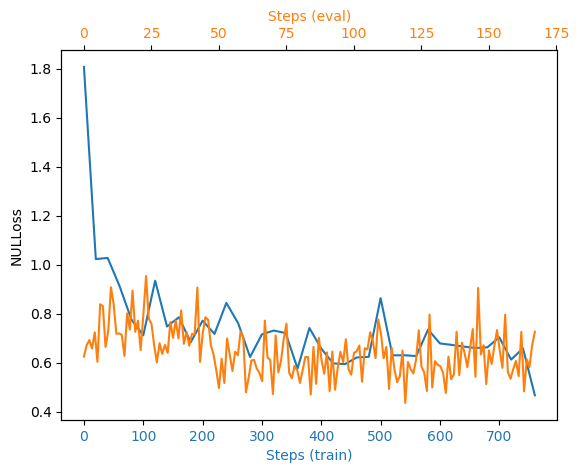

In [22]:
# Plot the loss over the steps for the train and testing cases
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_ylabel('NULLoss')
ax1.set_xlabel('Steps (train)', color = color)
ax1.plot(train_steps, train_steps_vals , color = color)
ax1.tick_params(axis ='x', labelcolor = color)

ax2 = ax1.twiny()
   
color = 'tab:orange'
ax2.set_xlabel('Steps (eval)', color = color)
ax2.plot(eval_steps, eval_steps_vals, color = color)
ax2.tick_params(axis ='x', labelcolor = color)

plt.savefig('eval_train_steps_loss.png')
plt.show()

The training loss started at 1.8 but decreased rapidly and maintained an average of 0.6 over the next steps. Meanwhile, the validation loss started low and maintained an average of 0.6. The fact that the validation loss kept fluctuating around the same average indicates over-training.

In [23]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"Profiler report location: {rule_output_path}")

Profiler report location: s3://sagemaker-us-east-1-966212731481/pytorch-training-2023-01-12-08-21-46-819/rule-output


In [24]:
! aws s3 ls {rule_output_path} --recursive

2023-01-12 08:38:21     416738 pytorch-training-2023-01-12-08-21-46-819/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-01-12 08:38:20     272428 pytorch-training-2023-01-12-08-21-46-819/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-01-12 08:38:14        528 pytorch-training-2023-01-12-08-21-46-819/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-01-12 08:38:14      63146 pytorch-training-2023-01-12-08-21-46-819/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-01-12 08:38:14       1857 pytorch-training-2023-01-12-08-21-46-819/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-01-12 08:38:15        332 pytorch-training-2023-01-12-08-21-46-819/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-01-12 08:38:15      25434 pytorch-training-2023-01-12-08-21-46-819/rule-output/ProfilerReport/profiler-output/profiler-re

In [25]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-966212731481/pytorch-training-2023-01-12-08-21-46-819/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-966212731481/pytorch-training-2023-01-12-08-21-46-819/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-966212731481/pytorch-training-2023-01-12-08-21-46-819/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-966212731481/pytorch-training-2023-01-12-08-21-46-819/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-966212731481/pytorch-training-2023-

In [26]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [162]:
import IPython
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [27]:
predictor=estimator.deploy(initial_instance_count=1, 
                           instance_type="ml.g4dn.xlarge") 

-----------!

In [127]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

model_location = estimator.output_path + estimator.latest_training_job.job_name + "/output/model.tar.gz"

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImgPredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )
        
pytorch_model = PyTorchModel( 
    						name='INTEL-image-classificationV6',
    						model_data = model_location,
    						entry_point= "inference.py",
                            role = role,
                            py_version = "py38",
                            framework_version = "1.10",
    						predictor_cls = ImgPredictor
                            )

predictor = pytorch_model.deploy( initial_instance_count = 1, instance_type = "ml.t2.medium")

Using already existing model: INTEL-image-classificationV6


--------------!

Now we test the deployed model on some random images from the predect file

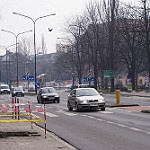

Model Image Classification: street
_________________________________________



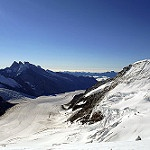

Model Image Classification: glacier
_________________________________________



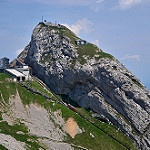

Model Image Classification: mountain
_________________________________________



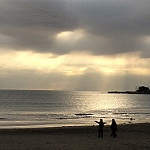

Model Image Classification: sea
_________________________________________



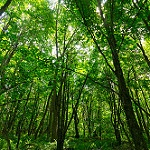

Model Image Classification: forest
_________________________________________



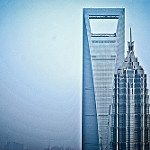

Model Image Classification: buildings
_________________________________________



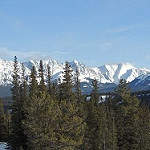

Model Image Classification: mountain
_________________________________________



In [160]:
from PIL import Image
from IPython.display import display
import io
import os
import numpy as np

test_dir = "./data/seg_pred/"
files = os.listdir(data_path)
num_test_images = 7

# Get #num_test_images random images
test_images = random.choices(files, k = num_test_images)

images_classes = {0: 'buildings',
                  1: 'forest',
                  2: 'glacier',
                  3: 'mountain',
                  4: 'sea',
                  5: 'street'}

for im in test_images:
    test_file_path = os.path.join(test_dir,im)
    with open(test_file_path , "rb") as f:
        img_bytes = f.read()
        display(Image.open(io.BytesIO(img_bytes)))
        response = predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})
        predicted_class = np.argmax(response,1)
        print(f"Model Image Classification: {images_classes[int(predicted_class)]}")
        print("_________________________________________\n")

For a quick model training of accuracy of 79%, the predicted classes are correct. The last image is a bit confusing as it has trees and mountains on covering the same area of the image.

In [161]:
#shutdown/delete the endpoint
predictor.delete_endpoint()